# Apartat 2. Sèries temporals amb Datashader

En aquest apartat farem feina amb el dataset de les dades de qualitat de l'aire per hores de Castella i Lleó. En concret, ens centrarem en l'estació Renault1 de la província Valladolid.

En la columna Fecha apareix la data i l'hora de cada mesura.

Volem representar gràficament aquesta sèrie temporal emprant Datashader. Heu d'obtenir les següents tres imatges

    Sèrie temporal de la variable monòxid de nitrogen (NO (ug/m3))
    Sèrie temporal de la variable diòxid de nitrogen (NO2 (ug/m3))
    Ambdues sèries en una única imatge, cada una d'un color diferent

In [6]:
# dependencies
!pip install datashader
!pip install dash

In [7]:
# dades
import pandas as pd

df = pd.read_csv('https://datosabiertos.jcyl.es/web/jcyl/risp/es/medio-ambiente/calidad-aire-historico-horario/1284808467480.csv', sep=';')
df.head()

<ipython-input-7-41b47dabcd90>:4: DtypeWarning: Columns (2,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://datosabiertos.jcyl.es/web/jcyl/risp/es/medio-ambiente/calidad-aire-historico-horario/1284808467480.csv', sep=';')


,Fecha,CO (mg/m3),NO (ug/m3),NO2 (ug/m3),O3 (ug/m3),PM10 (ug/m3),PM25 (ug/m3),SO2 (ug/m3),Provincia,Estación,Latitud,Longitud
0,31/12/2018 24,NaN,3.0,33.0,NaN,13.0,NaN,7.0,León,C.T.Compostilla-Compostilla,42.570833,-6.589444
1,31/12/2018 24,NaN,52.0,33.0,2.0,NaN,NaN,NaN,Valladolid,Renault1,41.600000,-4.732500
2,31/12/2018 24,NaN,9.0,22.0,41.0,7.0,NaN,8.0,Soria,Soria,41.766667,-2.466667
3,31/12/2018 24,NaN,2.0,2.0,50.0,1.0,1.0,NaN,Palencia,C.T.G. - Compuerto,42.849167,-4.835833
4,31/12/2018 24,NaN,1.0,9.0,34.0,4.0,NaN,1.0,León,C.T.L.R. - Cuadros,42.715556,-5.638889


In [8]:
# format a valladolid
def process_valladolid_data(df, station='Renault1', province='Valladolid'):
   """Process and clean Valladolid station data."""
   df_clean = df[
       (df['Estación'] == station) &
       (df['Provincia'] == province)
   ].copy()

   df_clean['Fecha'] = (pd.to_datetime(
       df_clean['Fecha'].astype(str).str.replace(
           r'(\d{2}/\d{2}/\d{4}) 24',
           r'\1 00',
           regex=True
       ),
       format='%d/%m/%Y %H',
       errors='coerce'
   ))

   midnight_mask = df_clean['Fecha'].dt.hour == 0
   df_clean.loc[midnight_mask, 'Fecha'] += pd.Timedelta(days=1)

   df_clean['Timestamp'] = df_clean['Fecha'].astype('int64') // 10**9
   return df_clean.dropna(subset=['Fecha', 'Timestamp'])

df_valladolid = process_valladolid_data(df)
print(df_valladolid)

                      Fecha  CO (mg/m3) NO (ug/m3)  NO2 (ug/m3) O3 (ug/m3)  \
1       2019-01-01 00:00:00         NaN       52.0         33.0        2.0   
97      2018-12-31 23:00:00         NaN       33.0         36.0        1.0   
137     2018-12-31 22:00:00         NaN       48.0         45.0        2.0   
173     2018-12-31 21:00:00         NaN       58.0         57.0        1.0   
222     2018-12-31 20:00:00         NaN       86.0         67.0        1.0   
...                     ...         ...        ...          ...        ...   
9651528 1997-01-01 05:00:00         NaN        2.0          3.0          6   
9651557 1997-01-01 04:00:00         NaN        2.0          3.0          6   
9651584 1997-01-01 03:00:00         NaN        2.0          3.0          6   
9651601 1997-01-01 02:00:00         NaN        2.0          3.0          6   
9651621 1997-01-01 01:00:00         NaN        2.0          3.0          6   

        PM10 (ug/m3) PM25 (ug/m3) SO2 (ug/m3)   Provincia  Esta

# 1. Monòxid de nirogen (NO mg/m3)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  wa

CPU times: user 46.2 ms, sys: 0 ns, total: 46.2 ms
Wall time: 57.7 ms


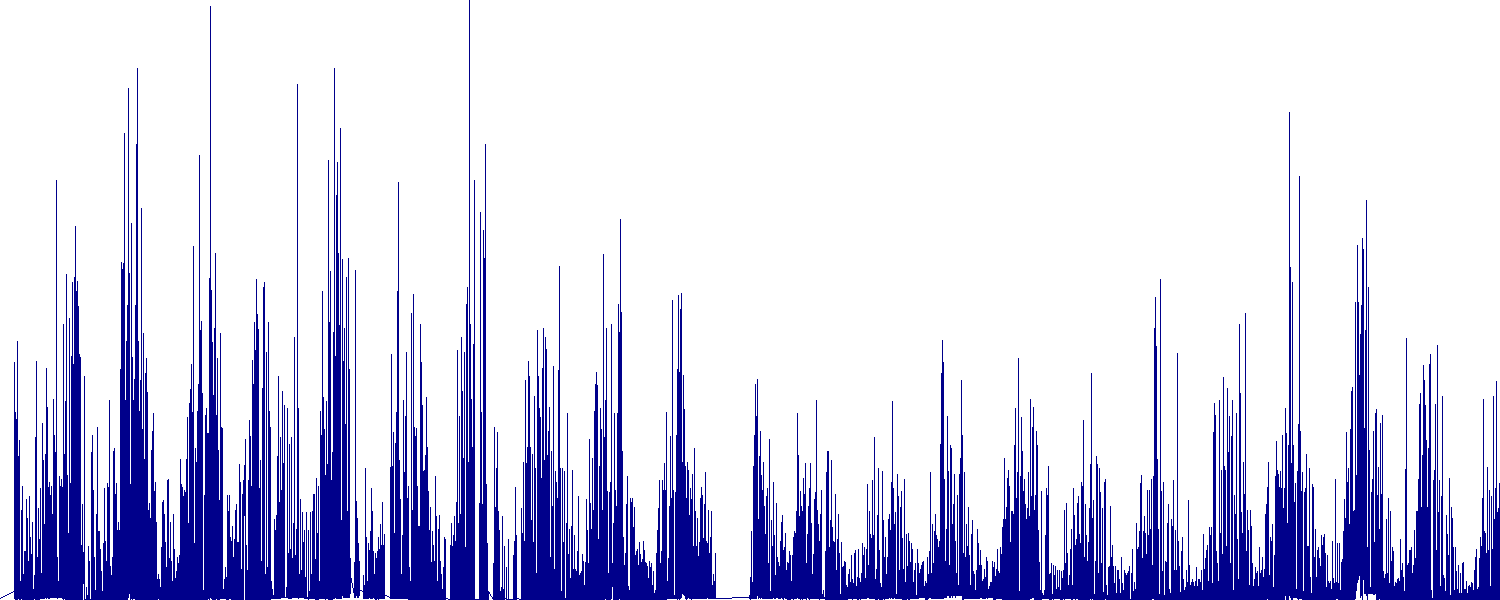

In [9]:
import datashader as ds
import datashader.transfer_functions as tf

df_no = df_valladolid[df_valladolid['NO (ug/m3)'].notna()].copy()
df_no['NO (ug/m3)'] = pd.to_numeric(df_no['NO (ug/m3)'], errors='coerce')

x_range_no = (df_no['Timestamp'].min(), df_no['Timestamp'].max())
y_range_no = (df_no['NO (ug/m3)'].min(), df_no['NO (ug/m3)'].max())

cvs_no = ds.Canvas(x_range=x_range_no, y_range=y_range_no, plot_height=600, plot_width=1500)
agg_no = cvs_no.line(df_no, 'Timestamp', 'NO (ug/m3)')

%time tf.shade(agg_no)

# 2. Diòxid de nitrogen (NO2 mg/m3)

CPU times: user 44.6 ms, sys: 0 ns, total: 44.6 ms
Wall time: 44.5 ms


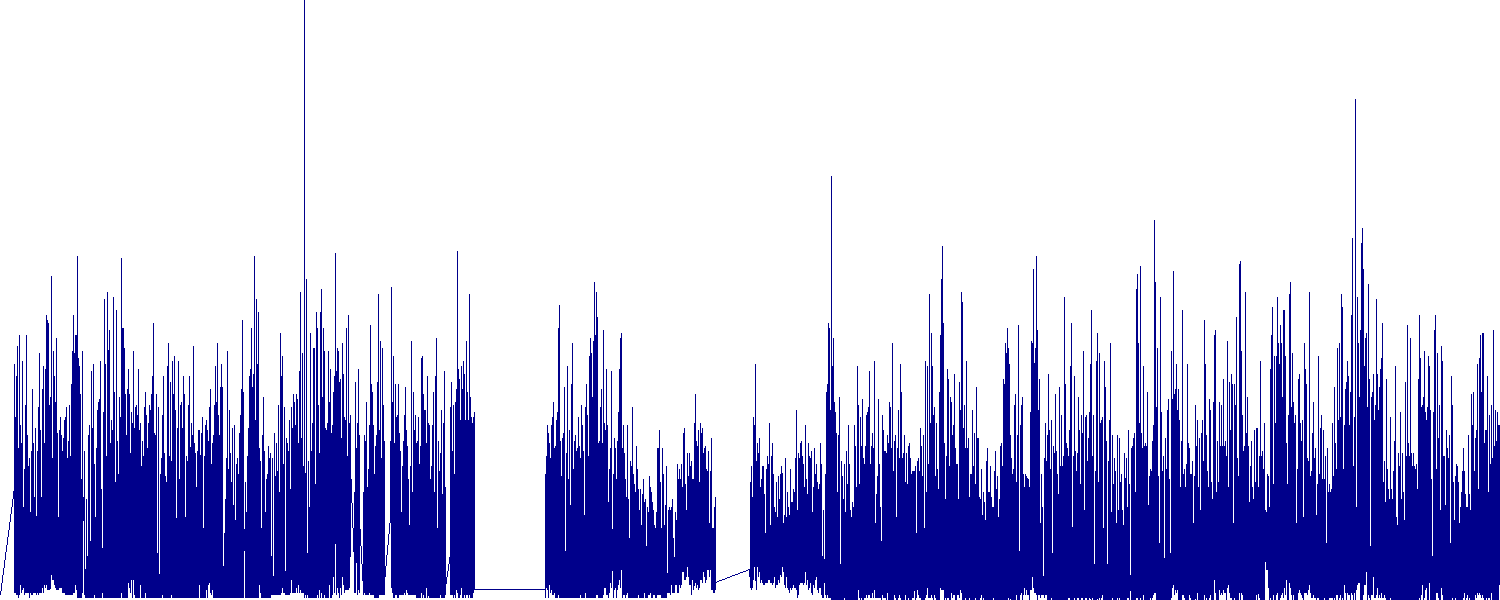

In [10]:
df_no2 = df_valladolid[df_valladolid['NO2 (ug/m3)'].notna()].copy()
df_no2['NO2 (ug/m3)'] = pd.to_numeric(df_no2['NO2 (ug/m3)'], errors='coerce')

x_range_no2 = (df_no2['Timestamp'].min(), df_no2['Timestamp'].max())
y_range_no2 = (df_no2['NO2 (ug/m3)'].min(), df_no2['NO2 (ug/m3)'].max())

cvs_no2 = ds.Canvas(x_range=x_range_no2, y_range=y_range_no2, plot_height=600, plot_width=1500)
agg_no2 = cvs_no2.line(df_no2, 'Timestamp', 'NO2 (ug/m3)')

%time tf.shade(agg_no2)

# 3. Amdós

CPU times: user 3.23 s, sys: 248 ms, total: 3.48 s
Wall time: 3.47 s


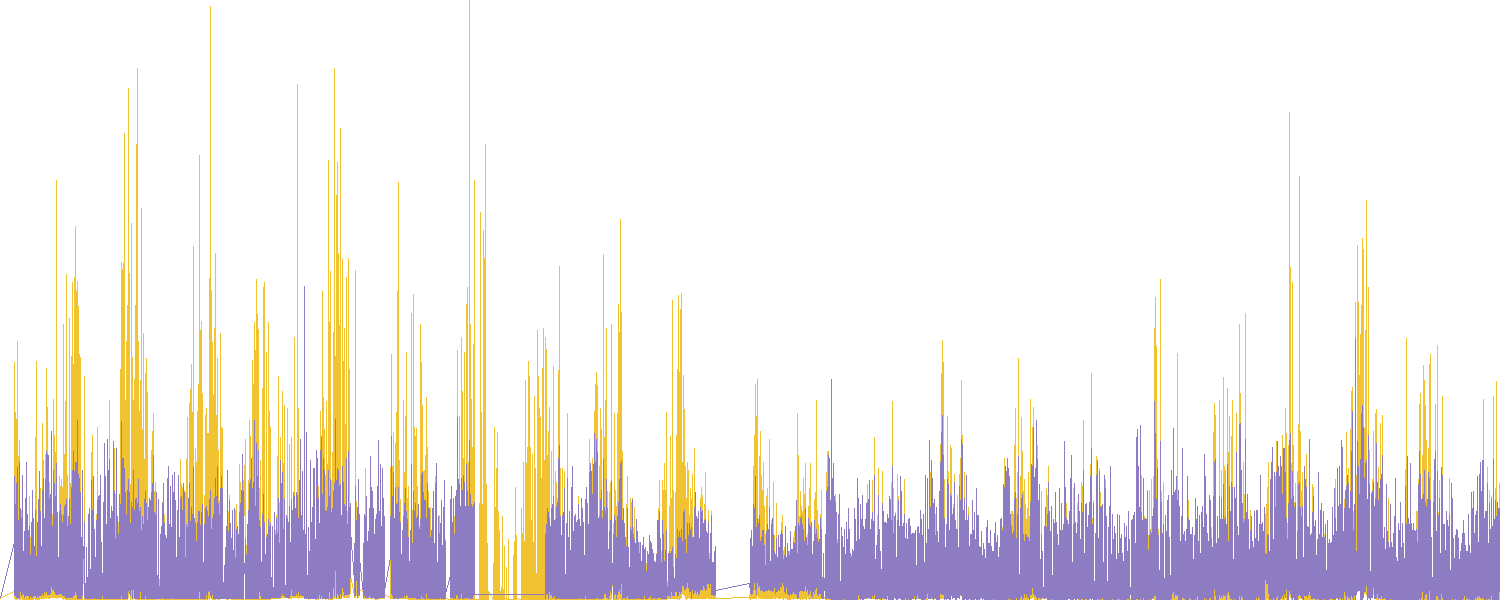

In [11]:
%%time

x_range_combined = (
    min(df_no['Timestamp'].min(), df_no2['Timestamp'].min()),
    max(df_no['Timestamp'].max(), df_no2['Timestamp'].max())
)
y_range_combined = (
    min(df_no['NO (ug/m3)'].min(), df_no2['NO2 (ug/m3)'].min()),
    max(df_no['NO (ug/m3)'].max(), df_no2['NO2 (ug/m3)'].max())
)

cvs_combined = ds.Canvas(x_range=x_range_combined, y_range=y_range_combined,
                        plot_height=600, plot_width=1500)

agg_no_combined = cvs_combined.line(df_no, 'Timestamp', 'NO (ug/m3)')
agg_no2_combined = cvs_combined.line(df_no2, 'Timestamp', 'NO2 (ug/m3)')

# Combine them with different colors
import datashader.transfer_functions as tf

result = tf.stack(
    tf.shade(agg_no_combined, cmap=['#f1c232']),
    tf.shade(agg_no2_combined, cmap=['#8e7cc3'])
)

# Display the result
result
